# Chapter 1 : Import  libraries and data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [4]:
df_train=pd.read_csv('/Users/abdul/Desktop/machine learning/data/home-data-for-ml-course/spaceship-titanic/train.csv')
df_test=pd.read_csv('/Users/abdul/Desktop/machine learning/data/home-data-for-ml-course/spaceship-titanic/test.csv')

In [5]:
print(df_train.shape)
print(df_test.shape)

(8693, 14)
(4277, 13)


The training data groups together 8693 individuals for  14 variables.
The validation data brings together 4277 individuals for 13 variables.

What we know about variables:
- PassgerID ==> form gggg_pp where the first part indicates in which group the individual is traveling and the second is the number in that group. We are told that people in a group are often from the same family.
- Cryosleep ==> people who said 'yes' are confined to their cabin.
- Cabin ==> form deck/num/side, where side can be P for port or S for starborad
- name ==> first name/last name form

# Chapitre 2 : EDA


In [6]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Numerical variable

In [7]:
# numerical columns
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
numerical_cols

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

In [8]:
# Describe the numerical columns
df_train[numerical_cols].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [9]:
(df_train['Transported'].value_counts()/df_train.shape[0])*100

Transported
True     50.362361
False    49.637639
Name: count, dtype: float64

We see that around 1/2 person has been transported in another dimension.

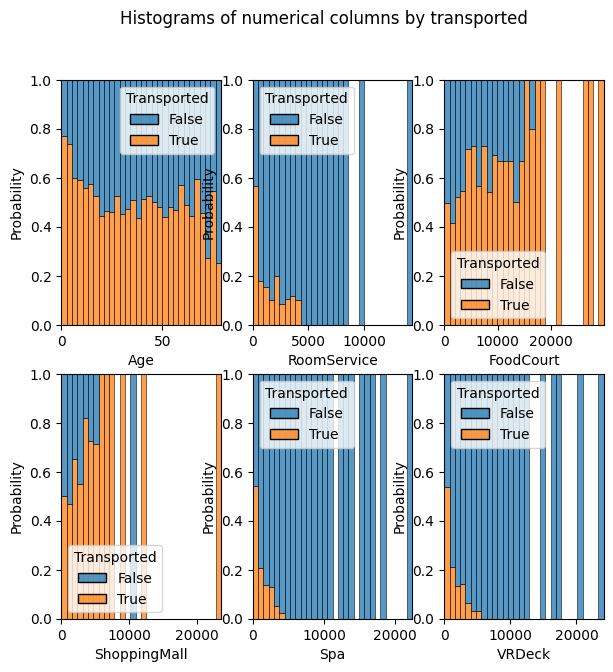

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(7, 7))
fig.suptitle('Histograms of numerical columns by transported')

# Flatten the axis array to access each subplot
ax = ax.flatten()
for i, col in enumerate(numerical_cols):
    sns.histplot(data=df_train, x=col, kde=False, color="skyblue", hue="Transported", multiple="fill", bins=30, stat='probability', ax=ax[i])
# Show the plot outside the loop
plt.show()

We see difference on the probability by 'Transported'. Let's see the missing value for the numerical variables.
- Young people (<30) have been more transported than other
- People with big bill in room service, spa and VRDeck have been less transported
- People with big foodcourt or shoppingmall have been more transported than other

In [11]:
data_num = df_train[numerical_cols]

In [12]:
# create a fonction for count missing values
def missing_values(x):
    missing_count= x.isnull().sum()
    percent_missing = (x.isna().sum()/x.shape[0])*100
    columns_with_missing_values= pd.DataFrame({'nom': missing_count.index,'Number missing':missing_count.values, 
                                               'percent missing':percent_missing.values})
    columns_with_missing_values=columns_with_missing_values[columns_with_missing_values['percent missing']>0]
    columns_with_missing_values=columns_with_missing_values.sort_values(by='percent missing',ascending=False)
    return columns_with_missing_values

In [13]:
missing_values(data_num)

,nom,Number missing,percent missing
3,ShoppingMall,208,2.392730
5,VRDeck,188,2.162660
2,FoodCourt,183,2.105142
4,Spa,183,2.105142
1,RoomService,181,2.082135
0,Age,179,2.059128


The percentage of missing value is arround 2%, it's acceptable so no need to remove variable. Simple imputation will work.

<Axes: >

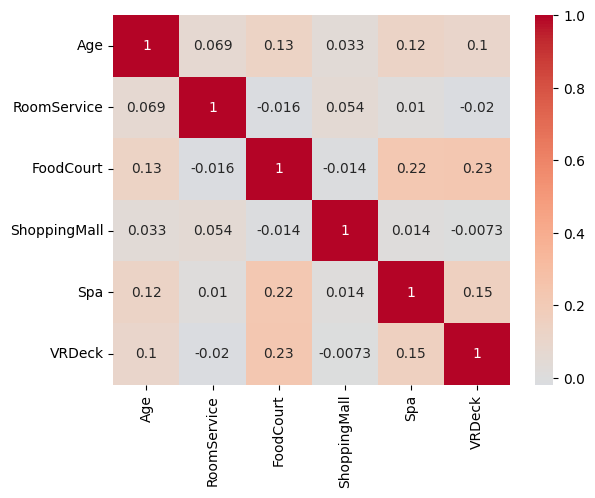

In [14]:
corr = data_num.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)

No big correlation between numerical variable

## Categorical variable

In [15]:
# categorical columns 
categorical_cols = df_train.select_dtypes(include=['object']).columns
categorical_cols

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name'],
      dtype='object')

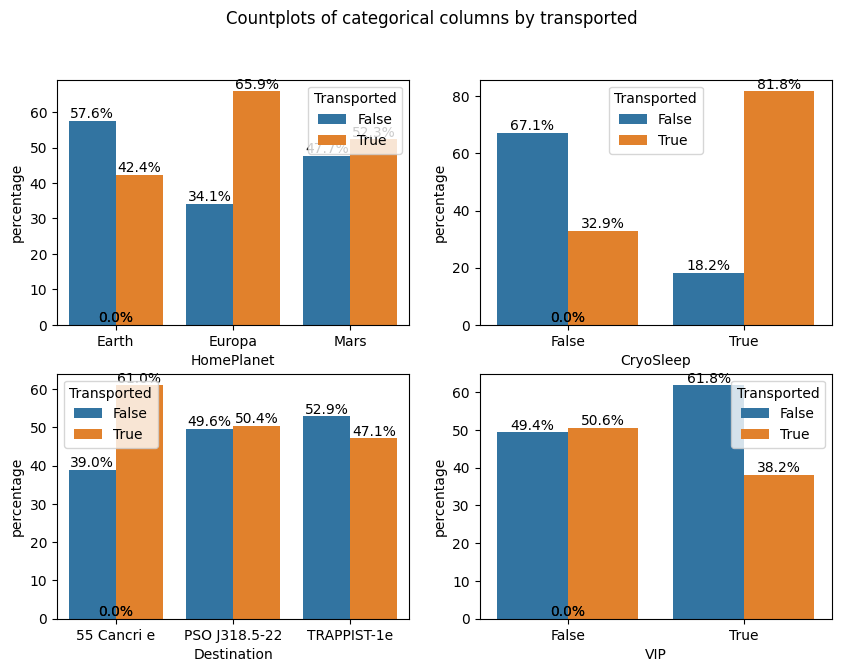

In [16]:
#split screen
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle('Countplots of categorical columns by transported')
#select the variables to plot
vars = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
# loop to create the countplots
for i, var in enumerate(vars):
    counts = df_train.groupby(var)['Transported'].value_counts(normalize=True).mul(100).reset_index(name='percentage')
    ax = sns.barplot(data=counts, x=var, y='percentage', hue='Transported', ax=axes[i//2, i%2])
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.show()

- People from Europa have been more transported (europa ++)
- Peapole in cryosleep have been more transported than other (81)
- People going to 55 cancrie have been more transported
- People with VIP ticket habe been less transported

In [17]:
data_cat = df_train[categorical_cols]
missing_values(data_cat)

,nom,Number missing,percent missing
2,CryoSleep,217,2.496261
5,VIP,203,2.335212
1,HomePlanet,201,2.312205
6,Name,200,2.300702
3,Cabin,199,2.289198
4,Destination,182,2.093639


Quantity of missing valeu <2.5 % so no need to remove

# Chapter 3 : Pre-processing

Objective:
- create group thanks passenger ID (first part indicates in which group the individual is traveling,group are often from the same family.)
- Create groupe thans cabin (deck/num/side, where side can be P for port or S for starborad)
- Find family thanks name (name/last name form)


In [18]:
df_train['groupe'] = df_train['PassengerId'].str[:4]
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,groupe
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280


Now we create a new varibale "is_travel_group" wher is true when the count of "groupe" is greater than 1

In [19]:
counts= df_train['groupe'].value_counts()
counts
df_train['is_travel_group']=df_train['groupe'].apply(lambda x: 1 if counts[x]>1 else 0 )
df_train['is_travel_group'].value_counts()/df_train.shape[0]*100

is_travel_group
0    55.274359
1    44.725641
Name: count, dtype: float64

Let's create the variable family

In [20]:
df_train['family']=df_train['Name'].str.split(" ").str[-1]
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,groupe,is_travel_group,family
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,0,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,0,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,1,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,1,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,0,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,0,Noxnuther
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,0,Mondalley
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,0,Connon
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280,1,Hontichre


Now we use the 2 variables 'is_travel_group' and 'family' to create the variable 'family_journey' which equal 1 if the person travel with at least one family member and equal 0 if it is not.

Of course, we suppose that 2 peaople cannot have the same family name if there in the same family. (big hypothesis)

In [21]:
df_train['family_journey'] = (df_train['is_travel_group'] == 1) & (df_train['family'].map(df_train['family'].value_counts()) >= 2)
df_train['family_journey'] = df_train['family_journey'].astype(int)
print(df_train.value_counts('family_journey'))
print(df_train['family_journey'].value_counts()/df_train.shape[0]*100)

family_journey
0    4938
1    3755
Name: count, dtype: int64
family_journey
0    56.804325
1    43.195675
Name: count, dtype: float64


In [22]:
df_train['Cabin']

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

Creation of 3 variable with cabin (deck/number/side)

In [23]:
save=df_train.copy()
df_train['deck'] = df_train['Cabin'].str[0]
df_train['number_cabin'] = df_train['Cabin'].str[1:].str.extract('(\d+)').astype(float)
df_train['side']=df_train['Cabin'].str[-1]
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,groupe,is_travel_group,family,family_journey,deck,number_cabin,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,0001,0,Ofracculy,0,B,0.0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,0002,0,Vines,0,F,0.0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,0003,1,Susent,1,A,0.0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,0003,1,Susent,1,A,0.0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,0004,0,Santantines,0,F,1.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,...,74.0,Gravior Noxnuther,False,9276,0,Noxnuther,0,A,98.0,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,...,0.0,Kurta Mondalley,False,9278,0,Mondalley,0,G,1499.0,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,...,0.0,Fayey Connon,True,9279,0,Connon,0,G,1500.0,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,...,3235.0,Celeon Hontichre,False,9280,1,Hontichre,1,E,608.0,S


In [24]:
columns_to_check = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# Initialiser la colonne 'luxury' à 0
df_train['luxury'] = 0

# Parcourir chaque ligne du dataframe
for index, row in df_train.iterrows():
    count = 0
    # Parcourir chaque colonne à vérifier
    for column in columns_to_check:
        # Vérifier si la valeur est supérieure à 1
        if row[column] > 1:
            count += 1
    # Assigner le nombre de valeurs supérieures à 1 à la colonne 'luxury'
    df_train.at[index, 'luxury'] = count

df_train['luxury'].value_counts()

luxury
0    3655
3    2015
2    1418
4    1074
1     355
5     176
Name: count, dtype: int64

In [25]:
# Accéder aux premières lignes des colonnes 'luxury', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'
df_train[['luxury', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].head(5)


,luxury,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,0.0,0.0,0.0,0.0,0.0
1,5,109.0,9.0,25.0,549.0,44.0
2,4,43.0,3576.0,0.0,6715.0,49.0
3,4,0.0,1283.0,371.0,3329.0,193.0
4,5,303.0,70.0,151.0,565.0,2.0


<Figure size 800x600 with 0 Axes>

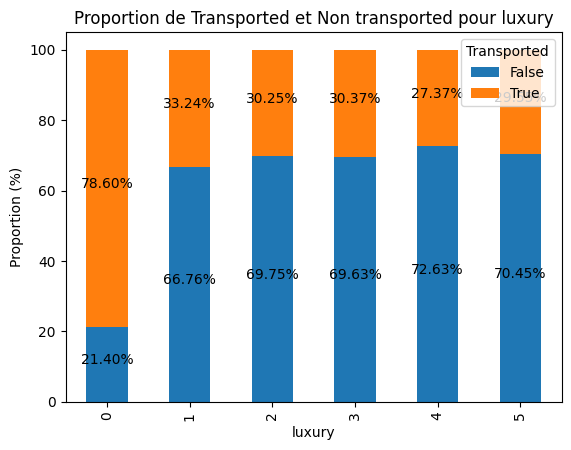

<Figure size 800x600 with 0 Axes>

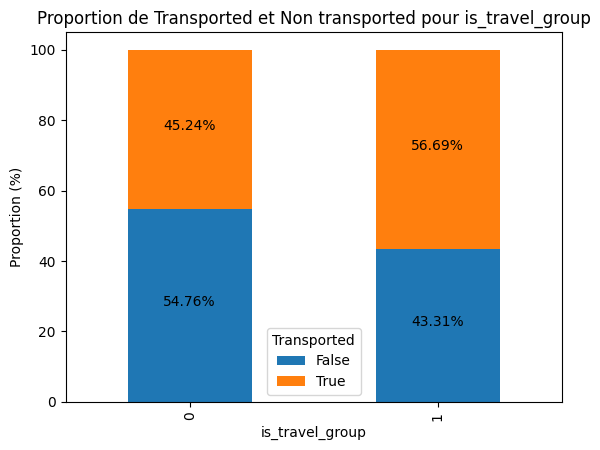

<Figure size 800x600 with 0 Axes>

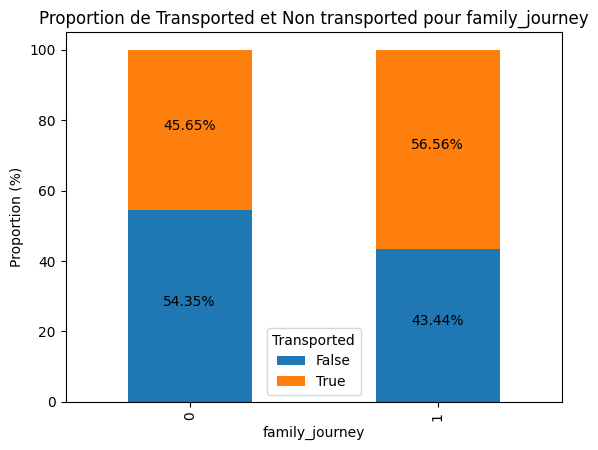

<Figure size 800x600 with 0 Axes>

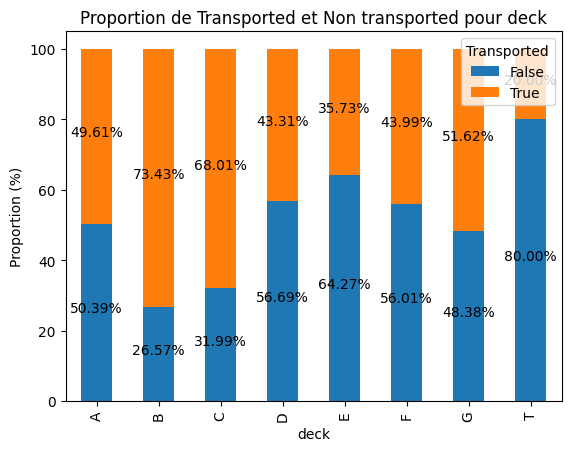

<Figure size 800x600 with 0 Axes>

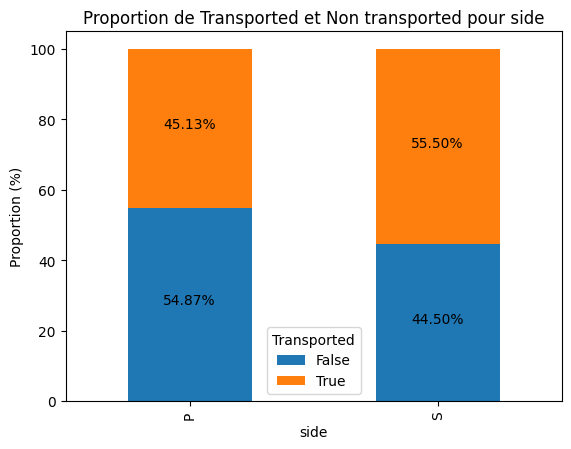

In [26]:
new_columns =['luxury','is_travel_group','family_journey','deck','side']
for colonne in new_columns:
    plt.figure(figsize=(8, 6))

    # Calcul des proportions de 'Transported' et 'Non transported' pour chaque catégorie
    proportions = df_train.groupby(colonne)['Transported'].value_counts(normalize=True).unstack() * 100

    # Création du diagramme en barres
    ax = proportions.plot(kind='bar', stacked=True)
    
    # Positionnement des étiquettes de pourcentage
    for i in range(len(proportions)):
        total = 0
        for value in proportions.iloc[i]:
            if not pd.isnull(value):
                ax.text(i, total + value / 2, f"{value:.2f}%", ha='center')
                total += value

    plt.title(f'Proportion de Transported et Non transported pour {colonne}')
    plt.xlabel(colonne)
    plt.ylabel('Proportion (%)')
    plt.legend(title='Transported')
    plt.show()

In [27]:
cross_table = pd.crosstab(df_train['is_travel_group'], df_train['family_journey'])
cross_table


family_journey,0,1
is_travel_group,,
0,4805,0
1,133,3755


Wee that 133 persons travel in group despite that they are not in family

In [28]:
df_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,groupe,is_travel_group,family,family_journey,deck,number_cabin,side,luxury
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,Maham Ofracculy,False,0001,0,Ofracculy,0,B,0.0,P,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,Juanna Vines,True,0002,0,Vines,0,F,0.0,S,5
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,Altark Susent,False,0003,1,Susent,1,A,0.0,S,4
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,Solam Susent,False,0003,1,Susent,1,A,0.0,S,4
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,Willy Santantines,True,0004,0,Santantines,0,F,1.0,S,5


## Cleaning/ encoding

In [29]:
#df_train=save.copy()
df_train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,groupe,is_travel_group,family,family_journey,deck,number_cabin,side,luxury
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,Maham Ofracculy,False,0001,0,Ofracculy,0,B,0.0,P,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,Juanna Vines,True,0002,0,Vines,0,F,0.0,S,5
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,Altark Susent,False,0003,1,Susent,1,A,0.0,S,4


In [30]:
save=df_train.copy()
df_train.drop(['PassengerId','Cabin','Name','groupe','family','number_cabin'], axis=1,inplace=True)

In [31]:
df_train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,is_travel_group,family_journey,deck,side,luxury
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0,0,B,P,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,0,F,S,5
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,1,1,A,S,4
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,1,1,A,S,4
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0,0,F,S,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,0,0,A,P,3
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,0,0,G,S,0
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,0,0,G,S,1
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,1,1,E,S,3


In [32]:
# is_travel_group, family_journey
df_train['is_travel_group']=df_train['is_travel_group'].astype('object')
df_train['family_journey']=df_train['family_journey'].astype('object')
df_train['Transported'] = df_train['Transported'].astype(int)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HomePlanet       8492 non-null   object 
 1   CryoSleep        8476 non-null   object 
 2   Destination      8511 non-null   object 
 3   Age              8514 non-null   float64
 4   VIP              8490 non-null   object 
 5   RoomService      8512 non-null   float64
 6   FoodCourt        8510 non-null   float64
 7   ShoppingMall     8485 non-null   float64
 8   Spa              8510 non-null   float64
 9   VRDeck           8505 non-null   float64
 10  Transported      8693 non-null   int64  
 11  is_travel_group  8693 non-null   object 
 12  family_journey   8693 non-null   object 
 13  deck             8494 non-null   object 
 14  side             8494 non-null   object 
 15  luxury           8693 non-null   int64  
dtypes: float64(6), int64(2), object(8)
memory usage: 1.1+ MB


In [33]:
ordinal_features = ['luxury']
target = ['Transported']
categorical_features=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side','is_travel_group','family_journey']
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# checking
len(ordinal_features) + len(categorical_features) + len(numerical_features) + len(target) == df_train.shape[1]

True

In [34]:
#Pipeline for numerical columns
num_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Pipeline for categorical columns
cat_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

# Pipeline for ordinal columns
ord_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

In [35]:
#Transformer for 3  types of columns

col_trans = ColumnTransformer(transformers=[
    ("num_p", num_pipeline, numerical_features),
    ("ode_p", ord_pipeline, ordinal_features),
    ("ohe_p", cat_pipeline, categorical_features),
], 
    remainder="passthrough",
    n_jobs=-1
)


# Pipeline fully completed
full_pipeline = Pipeline(steps=[
    ('preprocessor', col_trans),
    
])

## Splitting data training

In [36]:
# separate the target variable and the features
X=df_train.drop('Transported', axis=1)
y=df_train['Transported']
#Dim verif
print("X Shape :", X.shape)
print("y Shape :", y.shape)

X Shape : (8693, 15)
y Shape : (8693,)


In [37]:
X.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,is_travel_group,family_journey,deck,side,luxury
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,0,B,P,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,0,0,F,S,5
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,1,1,A,S,4


In [38]:
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num_p',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('ode_p',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['luxury']),
                                                 ('ohe_p',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'deck',
                                                   'side', 'is_travel_group',
                                                   'family_journey'])]))])

In [39]:
#Apply the pipeline
X_preprocessed = full_pipeline.fit_transform(X)

In [41]:
X_preprocessed.shape

(8693, 31)

In [44]:
# No NAs 
np.isnan(X_preprocessed).sum()

0

In [45]:
#Split X train/test et Y train/test
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [46]:
print("X train dim: ", X_train.shape)
print("Y train dim: ", y_train.shape)
print("X test dim: " , X_test.shape)
print("X test dim: " , y_test.shape)

X train dim:  (6954, 31)
Y train dim:  (6954,)
X test dim:  (1739, 31)
X test dim:  (1739,)


# Modeling training

In [75]:
# Import of libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from xgboost import XGBClassifier

In [77]:
# Define model to test
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'Xgboost': XGBClassifier()
}

# Parameter grinds for each model
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [3, 5, 7],
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2']
    },
    'Xgboost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.2,0.05, 0.01],
        'max_depth': [3, 5, 7],
    }
}

In [78]:
# Apply the grid search
results = {}
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    
    accuracy = grid_search.score(X_test, y_test)
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'test_accuracy': accuracy
    }
    print(f"Classifier: {model_name}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_}")
    print(f"Test accuracy: {accuracy}")
    print("----------------------------------------")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Classifier: RandomForest
Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation score: 0.8075932122741778
Test accuracy: 0.7924094307073031
----------------------------------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Classifier: GradientBoosting
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation score: 0.806298765444869
Test accuracy: 0.7912593444508338
----------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

Classifier: LogisticRegression
Best parameters: {'C': 1, 'penalty': 'l2'}
Best cross-validation score: 0.7972409477163056
Test accuracy: 0.7843588269120184
----------------------------------------
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Classifier: Xgboost
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation score: 0.8108997719150345
Test accuracy: 0.7952846463484762
----------------------------------------


We see that the best model is XGboost with accuracy of 0,7953. We will try to improve this one.

In [83]:
# Define the XGBoost classifier
xgb = XGBClassifier()

# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [3, 4, 5],  # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2]  # Learning rate
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid_search.fit(X_train, y_train)
accuracy = grid_search.score(X_test, y_test)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_score)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Best Accuracy Score: 0.8101812784136457


On arrive à 0.81 ce qui est mieux que la version avec le grid search précédant.

In [84]:
best_model = grid_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

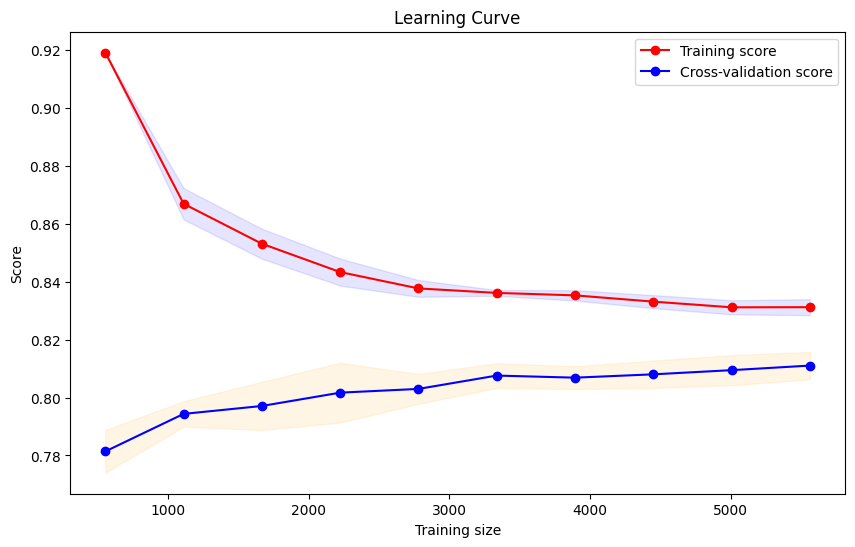

In [89]:
from sklearn.model_selection import learning_curve
# define sizes of the training set to use
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='accuracy', n_jobs=-1
)

# Calcul the mean and std of the scores on the training and test sets
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="blue")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="orange")
plt.plot(train_sizes, train_scores_mean, 'o-', color="red", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="blue", label="Cross-validation score")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Modeling on test data

In [100]:
#save.head(3)
#df_test=save
df_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


In [96]:
df_test.head(3)
#save=df_test.copy()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,groupe
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0013
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0018
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0019


In [101]:
# Prepare the test data
df_test['groupe'] = df_test['PassengerId'].str[:4]
counts= df_test['groupe'].value_counts()
counts
df_test['is_travel_group']=df_test['groupe'].apply(lambda x: 1 if counts[x]>1 else 0 )
df_test['family']=df_test['Name'].str.split(" ").str[-1]
df_test['family_journey'] = (df_test['is_travel_group'] == 1) & (df_test['family'].map(df_test['family'].value_counts()) >= 2)
df_test['family_journey'] = df_test['family_journey'].astype(int)
df_test['deck'] = df_test['Cabin'].str[0]
df_test['number_cabin'] = df_test['Cabin'].str[1:].str.extract('(\d+)').astype(float)
df_test['side']=df_test['Cabin'].str[-1]
columns_to_check = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# Initialiser la colonne 'luxury' à 0
df_test['luxury'] = 0

# Parcourir chaque ligne du dataframe
for index, row in df_test.iterrows():
    count = 0
    # Parcourir chaque colonne à vérifier
    for column in columns_to_check:
        # Vérifier si la valeur est supérieure à 1
        if row[column] > 1:
            count += 1
    # Assigner le nombre de valeurs supérieures à 1 à la colonne 'luxury'
    df_test.at[index, 'luxury'] = count


df_test.drop(['PassengerId','Cabin','Name','groupe','family','number_cabin'], axis=1,inplace=True)
df_test['is_travel_group']=df_test['is_travel_group'].astype('object')
df_test['family_journey']=df_test['family_journey'].astype('object')
ordinal_features = ['luxury']
categorical_features=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side','is_travel_group','family_journey']
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# checking
#len(ordinal_features) + len(categorical_features) + len(numerical_features) + len(target) == df_test.shape[1]


In [102]:
df_test.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,is_travel_group,family_journey,deck,side,luxury
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,0,0,G,S,0
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,0,0,F,S,2
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,0,0,C,S,0


In [104]:
df_test.shape

(4277, 15)

In [106]:
#Preprocessed au test set :
test_preprocessed = full_pipeline.fit_transform(df_test)
test_preprocessed.shape
# dimension ok ==> 31 columns

(4277, 31)

In [107]:
# Here best model trained
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [110]:
#Prediction
y_pred=best_model.predict(test_preprocessed)

In [112]:
df_test2=pd.read_csv('/Users/abdul/Desktop/machine learning/data/home-data-for-ml-course/spaceship-titanic/test.csv')
df_test2.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers


In [114]:
#Submission
submission = df_test2[['PassengerId']].copy()
submission['Transported'] = y_pred
submission['Transported'] = submission['Transported'].astype(bool)
submission.head()


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [115]:
# Save the submission
submission.to_csv('/Users/abdul/Desktop/machine learning/data/home-data-for-ml-course/spaceship-titanic/submission_spaceship.csv', index=False)

Top 38% in the rank
https://www.kaggle.com/competitions/spaceship-titanic/leaderboard#
